# Unsupervised Learning на датасете Adult

В этом ноутбуке исследуются методы unsupervised learning на датасете Adult. Сравниваются PCA, Autoencoder, Denoising Autoencoder и Variational Autoencoder с использованием нескольких протоколов оценки.


In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


## 1. Подготовка данных

Загружаем датасет Adult из OpenML и разделяем на train, validation и test выборки. Стратификация выполняется по целевой переменной (доход >50K), но метки не используются при обучении unsupervised моделей.

Preprocessing включает кодирование категориальных признаков и применение `StandardScaler` на train:

$$x_{\text{scaled}} = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}$$


In [26]:
adult = fetch_openml('adult', version=2, as_frame=True, parser='pandas')
X = adult.data
y = adult.target

print(f"Dataset shape: {X.shape}")
print(f"Target classes: {y.unique()}")
print(f"Target distribution: {y.value_counts().to_dict()}")


Dataset shape: (48842, 14)
Target classes: ['<=50K', '>50K']
Categories (2, object): ['<=50K', '>50K']
Target distribution: {'<=50K': 37155, '>50K': 11687}


In [27]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(exclude=[np.number])

for col in X_categorical.columns:
    X_categorical[col] = LabelEncoder().fit_transform(X_categorical[col].astype(str))

X_processed = pd.concat([X_numeric, X_categorical], axis=1)
X_processed = X_processed.values

X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Classes: {le.classes_}")


Train: (29304, 14), Val: (9769, 14), Test: (9769, 14)
Classes: ['<=50K' '>50K']


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

assert not np.isnan(X_train_scaled).any()
assert not np.isnan(X_val_scaled).any()
assert not np.isnan(X_test_scaled).any()

input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")


Input dimension: 14


Для оценки кластеризации используем исходные бинарные метки (<=50K и >50K).


In [29]:
y_train_groups = y_train
y_val_groups = y_val
y_test_groups = y_test

print(f"Class distribution (train): {np.bincount(y_train_groups)}")


Class distribution (train): [22292  7012]


## 2. Протоколы оценки

Определяем три протокола оценки для изученных представлений $z$:

### 2.1 Linear Probe

Обучаем линейный классификатор на замороженных представлениях для предсказания дохода:

$$P(y=1|z) = \sigma(w^\top z + b)$$

Оцениваем с помощью Accuracy и F1-score.

### 2.2 Кластеризация

Применяем K-Means кластеризацию на $z$ и измеряем согласованность с истинными метками через NMI и ARI:

$$\text{NMI}(C, Y) = \frac{2 \cdot I(C; Y)}{H(C) + H(Y)}$$

$$\text{ARI}(C, Y) = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}$$

### 2.3 Reconstruction Loss

Для методов на основе автоэнкодеров измеряем качество реконструкции:

$$\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^N \|x_i - \hat{x}_i\|^2$$


In [6]:
def linear_probe(z_train, y_train, z_val, y_val, z_test, y_test):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(z_train, y_train)
    
    y_val_pred = model.predict(z_val)
    y_test_pred = model.predict(z_test)
    
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='binary')
    test_f1 = f1_score(y_test, y_test_pred, average='binary')
    
    return {
        'val_acc': val_acc,
        'test_acc': test_acc,
        'val_f1': val_f1,
        'test_f1': test_f1
    }

def clustering_eval(z_train, y_train_groups, z_test, y_test_groups, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(z_train)
    
    clusters_test = kmeans.predict(z_test)
    
    nmi = normalized_mutual_info_score(y_test_groups, clusters_test)
    ari = adjusted_rand_score(y_test_groups, clusters_test)
    
    return {'nmi': nmi, 'ari': ari}

def reconstruction_loss(x, x_recon):
    return np.mean((x - x_recon) ** 2)


## 3. Бейзлайн: PCA

Principal Component Analysis проецирует данные на направления максимальной дисперсии:

$$z = W^\top (x - \mu)$$

где $W \in \mathbb{R}^{d \times d_z}$ содержит топ-$d_z$ собственных векторов ковариационной матрицы.

Реконструкция задается как:

$$\hat{x} = W z + \mu$$


In [8]:
pca_results = {}

for d_z in [2, 4, 8]:
    print(f"\nPCA with d_z={d_z}")
    
    pca = PCA(n_components=d_z, random_state=42)
    z_train = pca.fit_transform(X_train_scaled)
    z_val = pca.transform(X_val_scaled)
    z_test = pca.transform(X_test_scaled)
    
    probe_metrics = linear_probe(z_train, y_train, z_val, y_val, z_test, y_test)
    print(f"  Linear probe: Accuracy={probe_metrics['test_acc']:.4f}, F1={probe_metrics['test_f1']:.4f}")
    
    cluster_metrics = clustering_eval(z_train, y_train_groups, z_test, y_test_groups)
    print(f"  Clustering: NMI={cluster_metrics['nmi']:.4f}, ARI={cluster_metrics['ari']:.4f}")
    
    X_test_recon = pca.inverse_transform(z_test)
    recon_mse = reconstruction_loss(X_test_scaled, X_test_recon)
    print(f"  Reconstruction MSE: {recon_mse:.4f}")
    
    pca_results[d_z] = {
        'method': 'PCA',
        'd_z': d_z,
        'z_train': z_train,
        'z_val': z_val,
        'z_test': z_test,
        **probe_metrics,
        **cluster_metrics,
        'recon_mse': recon_mse
    }



PCA with d_z=2
  Linear probe: Accuracy=0.8015, F1=0.4468
  Clustering: NMI=0.0990, ARI=0.0366
  Reconstruction MSE: 0.7624

PCA with d_z=4
  Linear probe: Accuracy=0.8047, F1=0.4607
  Clustering: NMI=0.0953, ARI=0.0334
  Reconstruction MSE: 0.5844

PCA with d_z=8
  Linear probe: Accuracy=0.8274, F1=0.5465
  Clustering: NMI=0.0924, ARI=0.0316
  Reconstruction MSE: 0.2908


## 4. Undercomplete Autoencoder

Автоэнкодер состоит из энкодера $f_{\text{enc}}: \mathbb{R}^d \to \mathbb{R}^{d_z}$ и декодера $f_{\text{dec}}: \mathbb{R}^{d_z} \to \mathbb{R}^d$ с узким горлом $d_z < d$.

Цель — минимизировать reconstruction loss:

$$\mathcal{L}_{\text{AE}} = \mathbb{E}_{x \sim p_{\text{data}}} \left[ \|x - f_{\text{dec}}(f_{\text{enc}}(x))\|^2 \right]$$


In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


In [10]:
def train_autoencoder(model, train_loader, val_loader, epochs=100, lr=1e-3, patience=10, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            optimizer.zero_grad()
            x_recon, z = model(x_batch)
            loss = F.mse_loss(x_recon, x_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                x_recon, z = model(x_batch)
                loss = F.mse_loss(x_recon, x_batch)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [11]:
def extract_embeddings(model, X, device='cpu', batch_size=256):
    model.eval()
    dataset = TensorDataset(torch.FloatTensor(X))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings = []
    reconstructions = []
    
    with torch.no_grad():
        for x_batch in loader:
            x_batch = x_batch[0].to(device)
            x_recon, z = model(x_batch)
            embeddings.append(z.cpu().numpy())
            reconstructions.append(x_recon.cpu().numpy())
    
    return np.vstack(embeddings), np.vstack(reconstructions)


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

ae_results = {}

for d_z in [16, 32]:
    print(f"\n{'='*60}")
    print(f"Training Autoencoder with d_z={d_z}")
    print(f"{'='*60}")
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
    model = Autoencoder(input_dim, d_z)
    model = train_autoencoder(model, train_loader, val_loader, epochs=50, device=device)
    
    z_train, X_train_recon = extract_embeddings(model, X_train_scaled, device)
    z_val, X_val_recon = extract_embeddings(model, X_val_scaled, device)
    z_test, X_test_recon = extract_embeddings(model, X_test_scaled, device)
    
    probe_metrics = linear_probe(z_train, y_train, z_val, y_val, z_test, y_test)
    print(f"\nLinear probe: Accuracy={probe_metrics['test_acc']:.4f}, F1={probe_metrics['test_f1']:.4f}")
    
    cluster_metrics = clustering_eval(z_train, y_train_groups, z_test, y_test_groups)
    print(f"Clustering: NMI={cluster_metrics['nmi']:.4f}, ARI={cluster_metrics['ari']:.4f}")
    
    recon_mse = reconstruction_loss(X_test_scaled, X_test_recon)
    print(f"Reconstruction MSE: {recon_mse:.4f}")
    
    ae_results[d_z] = {
        'method': 'AE',
        'd_z': d_z,
        'z_train': z_train,
        'z_val': z_val,
        'z_test': z_test,
        **probe_metrics,
        **cluster_metrics,
        'recon_mse': recon_mse
    }


Using device: cuda

Training Autoencoder with d_z=16
Epoch 10/50, Train Loss: 0.0130, Val Loss: 0.0125
Epoch 20/50, Train Loss: 0.0041, Val Loss: 0.0040
Epoch 30/50, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 40/50, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 50/50, Train Loss: 0.0004, Val Loss: 0.0004

Linear probe: Accuracy=0.8328, F1=0.5711
Clustering: NMI=0.0019, ARI=0.0227
Reconstruction MSE: 0.0004

Training Autoencoder with d_z=32
Epoch 10/50, Train Loss: 0.0058, Val Loss: 0.0052
Epoch 20/50, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 30/50, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 40/50, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 50/50, Train Loss: 0.0002, Val Loss: 0.0001

Linear probe: Accuracy=0.8334, F1=0.5698
Clustering: NMI=0.0146, ARI=0.0648
Reconstruction MSE: 0.0002


## 5. Denoising Autoencoder

Denoising autoencoder (DAE) обучается восстанавливать чистые данные из зашумленных:

$$\tilde{x} = x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)$$

$$\mathcal{L}_{\text{DAE}} = \mathbb{E}_{x \sim p_{\text{data}}, \epsilon \sim \mathcal{N}(0, \sigma^2 I)} \left[ \|x - f_{\text{dec}}(f_{\text{enc}}(\tilde{x}))\|^2 \right]$$

Уровень шума $\sigma$ подбирается на validation выборке.


In [13]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, noise_std=0.1):
        super().__init__()
        self.noise_std = noise_std
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def add_noise(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.noise_std
            return x + noise
        return x
    
    def forward(self, x):
        x_noisy = self.add_noise(x)
        z = self.encode(x_noisy)
        x_recon = self.decode(z)
        return x_recon, z


In [14]:
def train_denoising_autoencoder(model, train_loader, val_loader, epochs=100, lr=1e-3, patience=10, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            optimizer.zero_grad()
            x_recon, z = model(x_batch)
            loss = F.mse_loss(x_recon, x_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                x_recon, z = model(x_batch)
                loss = F.mse_loss(x_recon, x_batch)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [15]:
dae_results = {}

for d_z in [16, 32]:
    print(f"\n{'='*60}")
    print(f"Training Denoising Autoencoder with d_z={d_z}")
    print(f"{'='*60}")
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
    noise_std = 0.1
    print(f"Noise std: {noise_std}")
    
    model = DenoisingAutoencoder(input_dim, d_z, noise_std=noise_std)
    model = train_denoising_autoencoder(model, train_loader, val_loader, epochs=50, device=device)
    
    z_train, X_train_recon = extract_embeddings(model, X_train_scaled, device)
    z_val, X_val_recon = extract_embeddings(model, X_val_scaled, device)
    z_test, X_test_recon = extract_embeddings(model, X_test_scaled, device)
    
    probe_metrics = linear_probe(z_train, y_train, z_val, y_val, z_test, y_test)
    print(f"\nLinear probe: Accuracy={probe_metrics['test_acc']:.4f}, F1={probe_metrics['test_f1']:.4f}")
    
    cluster_metrics = clustering_eval(z_train, y_train_groups, z_test, y_test_groups)
    print(f"Clustering: NMI={cluster_metrics['nmi']:.4f}, ARI={cluster_metrics['ari']:.4f}")
    
    recon_mse = reconstruction_loss(X_test_scaled, X_test_recon)
    print(f"Reconstruction MSE: {recon_mse:.4f}")
    
    dae_results[d_z] = {
        'method': 'DAE',
        'd_z': d_z,
        'z_train': z_train,
        'z_val': z_val,
        'z_test': z_test,
        **probe_metrics,
        **cluster_metrics,
        'recon_mse': recon_mse
    }



Training Denoising Autoencoder with d_z=16
Noise std: 0.1
Epoch 10/50, Train Loss: 0.0153, Val Loss: 0.0074
Epoch 20/50, Train Loss: 0.0103, Val Loss: 0.0032
Epoch 30/50, Train Loss: 0.0086, Val Loss: 0.0015
Epoch 40/50, Train Loss: 0.0080, Val Loss: 0.0010
Epoch 50/50, Train Loss: 0.0078, Val Loss: 0.0012

Linear probe: Accuracy=0.8305, F1=0.5633
Clustering: NMI=0.0000, ARI=-0.0025
Reconstruction MSE: 0.0012

Training Denoising Autoencoder with d_z=32
Noise std: 0.1
Epoch 10/50, Train Loss: 0.0141, Val Loss: 0.0062
Epoch 20/50, Train Loss: 0.0095, Val Loss: 0.0022
Epoch 30/50, Train Loss: 0.0081, Val Loss: 0.0019
Epoch 40/50, Train Loss: 0.0077, Val Loss: 0.0012
Epoch 50/50, Train Loss: 0.0076, Val Loss: 0.0010

Linear probe: Accuracy=0.8328, F1=0.5722
Clustering: NMI=0.0010, ARI=-0.0134
Reconstruction MSE: 0.0010


## 6. Variational Autoencoder

VAE обучает вероятностное латентное представление через максимизацию Evidence Lower Bound (ELBO):

$$\mathcal{L}_{\text{VAE}} = \mathbb{E}_{q_\phi(z|x)} \left[ \log p_\theta(x|z) \right] - \beta \cdot D_{\text{KL}}(q_\phi(z|x) \| p(z))$$

где $q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \text{diag}(\sigma_\phi^2(x)))$ — энкодер, а $p(z) = \mathcal{N}(0, I)$ — prior.

Reparameterization trick позволяет пропускать градиенты:

$$z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

KL-дивергенция имеет замкнутую форму:

$$D_{\text{KL}}(q_\phi(z|x) \| p(z)) = \frac{1}{2} \sum_{j=1}^{d_z} \left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right)$$


In [16]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        self.encoder_shared = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder_shared(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar) # batch x 32
            eps = torch.randn_like(std) # batch x 32
            return mu + eps * std
        return mu
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [17]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss, recon_loss, kl_loss


In [18]:
def train_vae(model, train_loader, val_loader, epochs=100, lr=1e-3, beta=1.0, patience=10, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_recon = 0
        train_kl = 0
        
        for x_batch in train_loader:
            x_batch = x_batch[0].to(device)
            
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x_batch)
            loss, recon_loss, kl_loss = vae_loss(x_recon, x_batch, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_recon += recon_loss.item()
            train_kl += kl_loss.item()
        
        model.eval()
        val_loss = 0
        val_recon = 0
        val_kl = 0
        
        with torch.no_grad():
            for x_batch in val_loader:
                x_batch = x_batch[0].to(device)
                x_recon, mu, logvar = model(x_batch)
                loss, recon_loss, kl_loss = vae_loss(x_recon, x_batch, mu, logvar, beta)
                val_loss += loss.item()
                val_recon += recon_loss.item()
                val_kl += kl_loss.item()
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"  Train Recon: {train_recon/len(train_loader.dataset):.4f}, Train KL: {train_kl/len(train_loader.dataset):.4f}")
            print(f"  Val Recon: {val_recon/len(val_loader.dataset):.4f}, Val KL: {val_kl/len(val_loader.dataset):.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    return model


In [19]:
def extract_vae_embeddings(model, X, device='cpu', batch_size=256):
    model.eval()
    dataset = TensorDataset(torch.FloatTensor(X))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings = []
    reconstructions = []
    
    with torch.no_grad():
        for x_batch in loader:
            x_batch = x_batch[0].to(device)
            x_recon, mu, logvar = model(x_batch)
            embeddings.append(mu.cpu().numpy())
            reconstructions.append(x_recon.cpu().numpy())
    
    return np.vstack(embeddings), np.vstack(reconstructions)


In [20]:
vae_results = {}

for d_z in [16, 32]:
    print(f"\n{'='*60}")
    print(f"Training VAE with d_z={d_z}, beta=1.0")
    print(f"{'='*60}")
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
    model = VAE(input_dim, d_z)
    model = train_vae(model, train_loader, val_loader, epochs=50, beta=1.0, device=device)
    
    z_train, X_train_recon = extract_vae_embeddings(model, X_train_scaled, device)
    z_val, X_val_recon = extract_vae_embeddings(model, X_val_scaled, device)
    z_test, X_test_recon = extract_vae_embeddings(model, X_test_scaled, device)
    
    probe_metrics = linear_probe(z_train, y_train, z_val, y_val, z_test, y_test)
    print(f"\nLinear probe: Accuracy={probe_metrics['test_acc']:.4f}, F1={probe_metrics['test_f1']:.4f}")
    
    cluster_metrics = clustering_eval(z_train, y_train_groups, z_test, y_test_groups)
    print(f"Clustering: NMI={cluster_metrics['nmi']:.4f}, ARI={cluster_metrics['ari']:.4f}")
    
    recon_mse = reconstruction_loss(X_test_scaled, X_test_recon)
    print(f"Reconstruction MSE: {recon_mse:.4f}")
    
    vae_results[d_z] = {
        'method': 'VAE',
        'd_z': d_z,
        'z_train': z_train,
        'z_val': z_val,
        'z_test': z_test,
        **probe_metrics,
        **cluster_metrics,
        'recon_mse': recon_mse
    }



Training VAE with d_z=16, beta=1.0
Epoch 10/50, Train Loss: 9.7033, Val Loss: 7.9268
  Train Recon: 6.5568, Train KL: 3.1464
  Val Recon: 4.7972, Val KL: 3.1296
Epoch 20/50, Train Loss: 9.1658, Val Loss: 7.2405
  Train Recon: 5.3972, Train KL: 3.7686
  Val Recon: 3.5219, Val KL: 3.7186
Epoch 30/50, Train Loss: 9.0388, Val Loss: 7.1735
  Train Recon: 5.1572, Train KL: 3.8815
  Val Recon: 3.2640, Val KL: 3.9095
Epoch 40/50, Train Loss: 8.9596, Val Loss: 7.0486
  Train Recon: 5.0241, Train KL: 3.9356
  Val Recon: 3.0684, Val KL: 3.9802
Epoch 50/50, Train Loss: 8.8769, Val Loss: 7.0364
  Train Recon: 4.9158, Train KL: 3.9611
  Val Recon: 3.0145, Val KL: 4.0219

Linear probe: Accuracy=0.8115, F1=0.4949
Clustering: NMI=0.0398, ARI=0.0001
Reconstruction MSE: 0.2145

Training VAE with d_z=32, beta=1.0
Epoch 10/50, Train Loss: 10.4582, Val Loss: 8.9378
  Train Recon: 8.0793, Train KL: 2.3789
  Val Recon: 6.5560, Val KL: 2.3818
Epoch 20/50, Train Loss: 9.4429, Val Loss: 7.8795
  Train Recon: 6.

## 7. Сравнение и сводка результатов

Сравниваем все методы по различным латентным размерностям с использованием трех протоколов оценки.


In [21]:
all_results = []

for d_z, results in pca_results.items():
    all_results.append({
        'Method': 'PCA',
        'd_z': d_z,
        'Test Accuracy': results['test_acc'],
        'Test F1': results['test_f1'],
        'NMI': results['nmi'],
        'ARI': results['ari'],
        'Recon MSE': results['recon_mse']
    })

for d_z, results in ae_results.items():
    all_results.append({
        'Method': 'AE',
        'd_z': d_z,
        'Test Accuracy': results['test_acc'],
        'Test F1': results['test_f1'],
        'NMI': results['nmi'],
        'ARI': results['ari'],
        'Recon MSE': results['recon_mse']
    })

for d_z, results in dae_results.items():
    all_results.append({
        'Method': 'DAE',
        'd_z': d_z,
        'Test Accuracy': results['test_acc'],
        'Test F1': results['test_f1'],
        'NMI': results['nmi'],
        'ARI': results['ari'],
        'Recon MSE': results['recon_mse']
    })

for d_z, results in vae_results.items():
    all_results.append({
        'Method': 'VAE',
        'd_z': d_z,
        'Test Accuracy': results['test_acc'],
        'Test F1': results['test_f1'],
        'NMI': results['nmi'],
        'ARI': results['ari'],
        'Recon MSE': results['recon_mse']
    })

results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("SUMMARY OF ALL METHODS")
print("="*80)
print(results_df.to_string(index=False))



SUMMARY OF ALL METHODS
Method  d_z  Test Accuracy  Test F1      NMI       ARI  Recon MSE
   PCA    2       0.801515 0.446790 0.098973  0.036584   0.762356
   PCA    4       0.804688 0.460712 0.095326  0.033382   0.584428
   PCA    8       0.827413 0.546530 0.092362  0.031641   0.290765
    AE   16       0.832839 0.571053 0.001916  0.022739   0.000404
    AE   32       0.833350 0.569767 0.014613  0.064764   0.000168
   DAE   16       0.830484 0.563291 0.000034 -0.002500   0.001158
   DAE   32       0.832839 0.572177 0.001049 -0.013377   0.000971
   VAE   16       0.811547 0.494925 0.039791  0.000086   0.214457
   VAE   32       0.806940 0.474359 0.068512  0.060435   0.261526


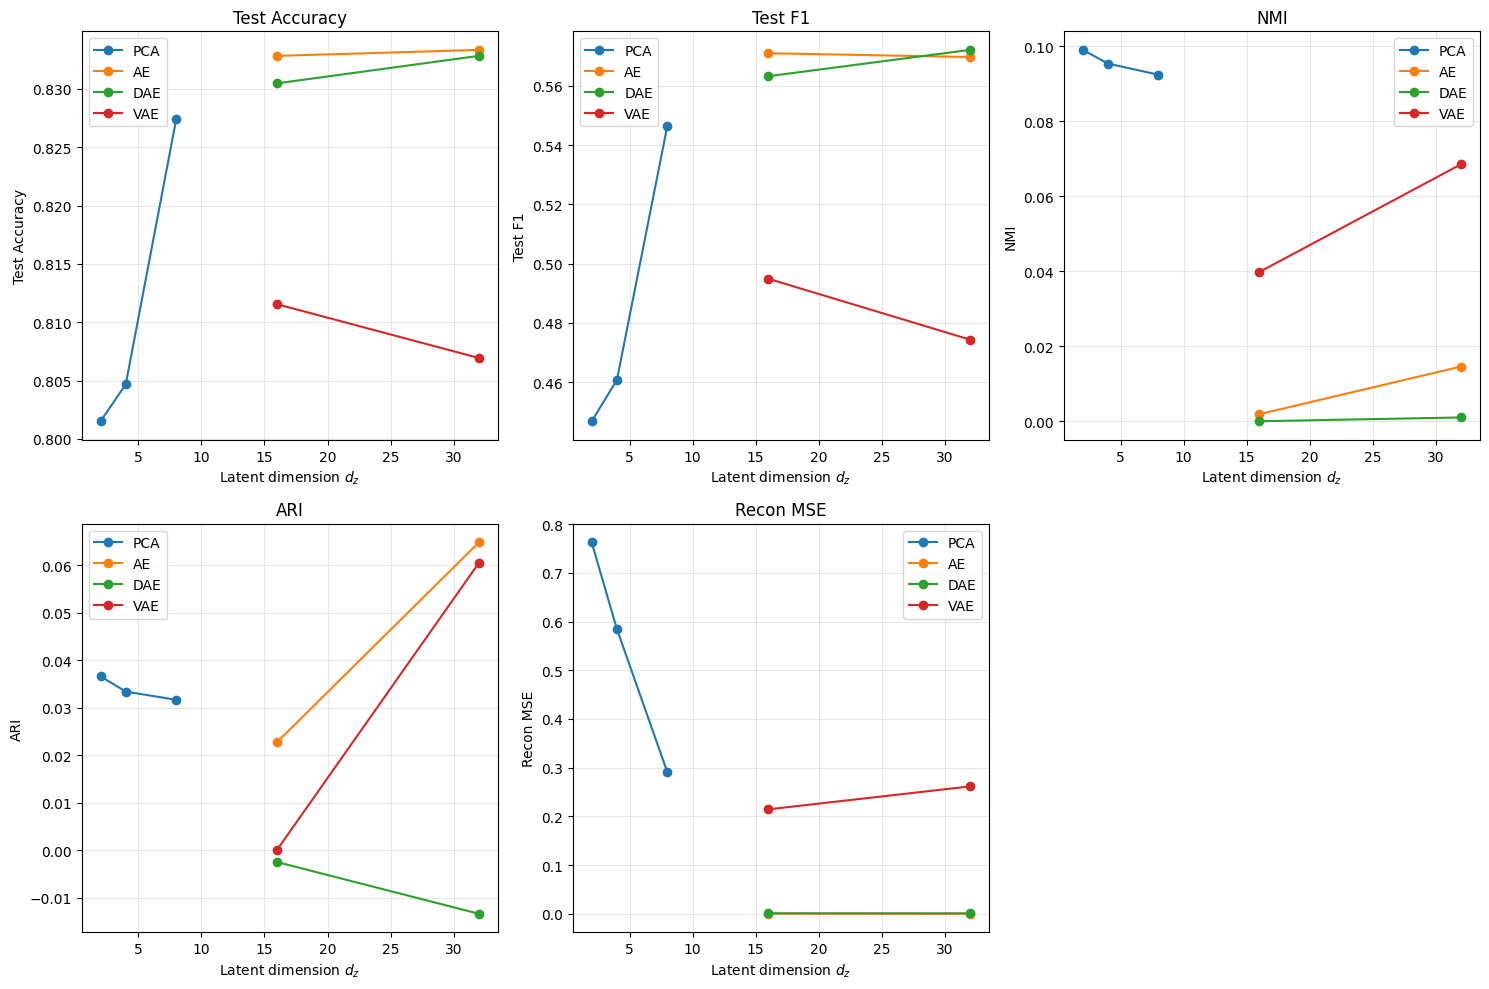

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics = ['Test Accuracy', 'Test F1', 'NMI', 'ARI', 'Recon MSE']
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    for method in ['PCA', 'AE', 'DAE', 'VAE']:
        method_data = results_df[results_df['Method'] == method]
        if len(method_data) > 0:
            ax.plot(method_data['d_z'], method_data[metric], marker='o', label=method)
    
    ax.set_xlabel('Latent dimension $d_z$')
    ax.set_ylabel(metric)
    ax.set_title(metric)
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


## 8. Визуализация: 2D проекции

Применяем t-SNE для визуализации изученных представлений в 2D с раскраской по классам дохода.


In [23]:
def plot_2d_projection(z, y_labels, title, method='t-SNE'):
    if z.shape[1] > 2:
        if method == 't-SNE':
            projector = TSNE(n_components=2, random_state=42, perplexity=30)
            z_2d = projector.fit_transform(z)
        else:
            projector = PCA(n_components=2, random_state=42)
            z_2d = projector.fit_transform(z)
    else:
        z_2d = z
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels, cmap='coolwarm', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Income Class', ticks=[0, 1])
    plt.xlabel(f'{method} Dimension 1')
    plt.ylabel(f'{method} Dimension 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


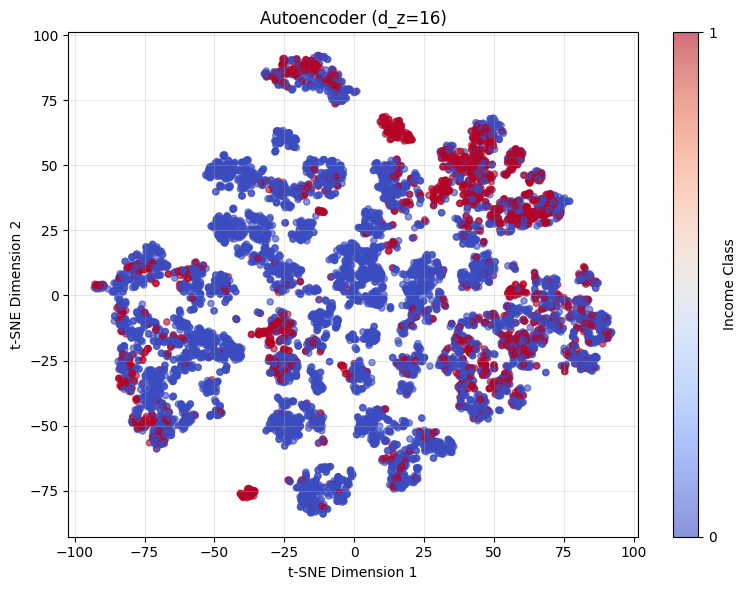

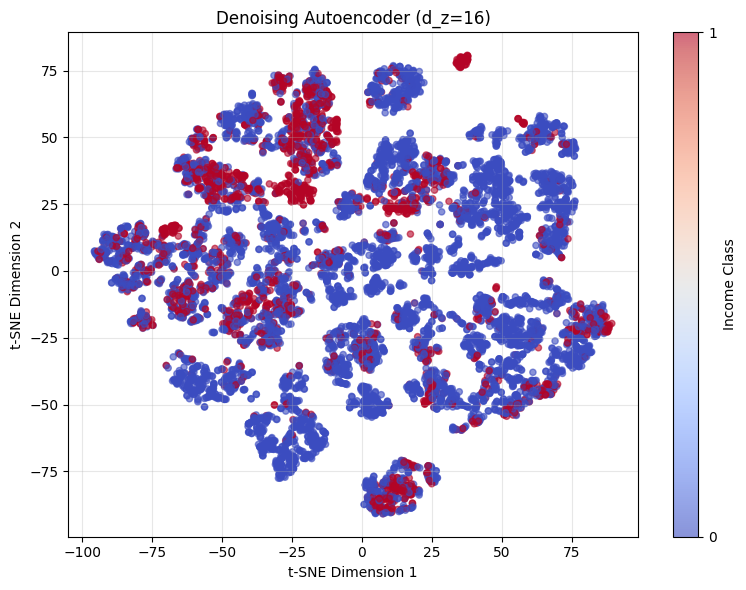

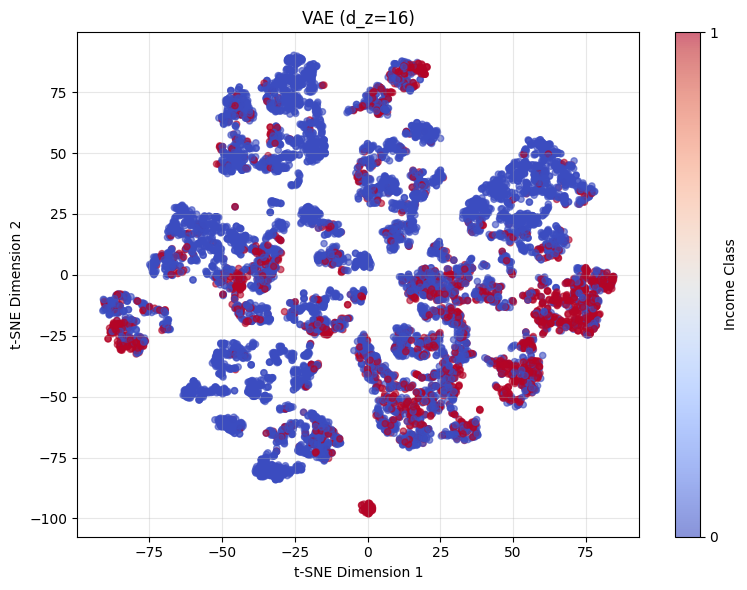

In [24]:
selected_d_z = 16

if selected_d_z in pca_results:
    plot_2d_projection(pca_results[selected_d_z]['z_test'], y_test_groups, f'PCA (d_z={selected_d_z})')

if selected_d_z in ae_results:
    plot_2d_projection(ae_results[selected_d_z]['z_test'], y_test_groups, f'Autoencoder (d_z={selected_d_z})')

if selected_d_z in dae_results:
    plot_2d_projection(dae_results[selected_d_z]['z_test'], y_test_groups, f'Denoising Autoencoder (d_z={selected_d_z})')

if selected_d_z in vae_results:
    plot_2d_projection(vae_results[selected_d_z]['z_test'], y_test_groups, f'VAE (d_z={selected_d_z})')
